<a href="https://colab.research.google.com/github/PatrickRaborn/DS-Unit-2-Kaggle-Challenge/blob/master/DS_Sprint_Challenge_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders

 
# Sprint Challenge: Predict Steph Curry's Shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

You'll create a model to predict whether Curry will make a shot based on his past perfomance.

# Directions

This notebook contains 10 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Feature engineering.
- **Task 3:** Splitting data into a feature matrix and target vector.
- **Task 4:** Splitting data into training, validation, and test sets.
- **Task 5:** Establishing baseline accuracy.
- **Task 6:** Building a model with a transformer and a tree-based predictor.
- **Task 7:** Calculating training and validation accuracy.
- **Task 8 (`stretch goal`):** Tuning model hyperparameters.
- **Task 9:** Calculating precision and recall from a confusion matrix.
- **Task 10 (`stretch goal`):** Plotting a confusion matrix.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise 
NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`



In [84]:
# import all the things 
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set at the index. 

In [64]:
'''T1. Import DataFrame `df`'''

import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
# YOUR CODE HERE
df = pd.read_csv(url, parse_dates= ['game_date'],
                 index_col= 'game_date')

In [30]:
df['shot_made_flag']

0    7357
1    6601
Name: shot_made_flag, dtype: int64

In [22]:
df['shot_zone_basic'].value_counts()

Above the Break 3        5695
Mid-Range                3194
Restricted Area          2692
In The Paint (Non-RA)    1250
Left Corner 3             603
Right Corner 3            428
Backcourt                  96
Name: shot_zone_basic, dtype: int64

In [65]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0


In [26]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex

**Task 1 Testing**

In [66]:
'''T1 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 13958, 'Is `df` the correct length?'


**Task 2a:** Engineer at least 1 new feature. You can use something from the list below or your own idea.

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**Task 2b (`stretch goal — optional`):** Create a total of 3 new features, using your own ideas or the list above. Make sure you're not just duplicating features that are already in the feature matrix.

In [67]:
"""T2. Create new feature"""

# YOUR CODE HERE
#create homecourt advantage
df['homecourt_adv'] = df['htm'].apply(lambda x : 0 if x =='GSW' else 1)


In [45]:
df.columns

Index(['game_id', 'game_event_id', 'period', 'minutes_remaining',
       'seconds_remaining', 'action_type', 'shot_type', 'shot_zone_basic',
       'shot_zone_area', 'shot_zone_range', 'shot_distance', 'loc_x', 'loc_y',
       'shot_made_flag', 'htm', 'vtm', 'season_type',
       'scoremargin_before_shot', 'homecourt_adv'],
      dtype='object')

**Task 2 Test**

In [68]:
'''T2 Testing'''

assert df.shape[1] >= 20, '`df` does not appear to have new features.'


# II. Split Data

**Task 3:** Divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'shot_made_flag'`.

In [69]:
'''T3. Create `X` and `y`.'''
# YOUR CODE HERE
target = 'shot_made_flag'
X = df.drop(columns=target)
y = df[target]

**Task 3 Test**

In [70]:
'''T3 Tests'''

assert y.shape == (13958,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 13958, '`X` has the wrong number of rows.'
assert X.shape[1] > 1, '`X` has the wrong number of columns'
assert 'shot_made_flag' not in X.columns, 'Target is still part of feature matrix.' 

**Task 4:** Divide your dataset into training, validation, and test sets. 

- Your training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the end of the 2016-17 season.
- Your validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Your test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.
- **Tip:** The NBA season begins in October and ends in June.

In [71]:
'''T4. Create training and val'''
# YOUR CODE HERE
#training data
cutoff = '2017-06-18'
mask = X.index < cutoff
X_train, y_train = X.loc[mask], y.loc[mask]
#validation 
cutoff2 = '2018-06-17'
mask2 = (X.index > cutoff) & (X.index < cutoff2)
X_val, y_val = X.loc[mask2],y.loc[mask2]
# test
mask3 = (X.index > cutoff2)
X_test, y_test = X.loc[mask3], y.loc[mask3]

**Test 4**

In [72]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


# III. Establish Baseline

**Task 5:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [74]:
'''T5. Calculate baseline accuracy `baseline_acc`.'''

# YOUR CODE HERE
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5272087356736757


**Task 5 Testing**

In [76]:
'''T5 Testing'''

assert isinstance(baseline_acc, float)
assert 0.0 <= baseline_acc <= 1.0


# IV. Build Model

**Task 6:** Build a model that includes (1) a transformer for categorical features and (2) a tree-based predictor. You should combine these two components (and any other pieces you think are necessary) in a pipeline named `model`. Be sure to fit your model to your training data.

In [77]:
'''T6. Build a pipeline `model` with encoder and tree-based predictor.'''

# YOUR CODE HERE
model = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier()

)
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['player_name', 'action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'htm', 'vtm',
                                      'season_type'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'player_name',
                                          'data_type': dtype('O'),
                                          'mapping': Stephen Curry    1
NaN             -2
dtype: int64},
                                         {'...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                   

**Task 6 Testing**

In [78]:
'''T6 Testing'''

from sklearn.pipeline import Pipeline
assert isinstance(model, Pipeline), '`model` should be type `Pipeline`.'

# Does `model` Pipeline have multiple components?
assert len(model.named_steps.keys()) > 1, '`model` should have more than one component.'

# Has `model` been trained?
assert hasattr(model, 'classes_'), 'Have you trained `model`?'


# V. Check Metrics

**Task 7:** Check the training and validation accuracy of your model, and assign the scores to `train_acc` and `val_acc` respectively.

In [81]:
'''T7. Calculate train and test accuracy.'''

# YOUR CODE HERE
train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)
print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 1.0
Validation Accuracy Score: 0.5873287671232876


**Task 7 Test**

In [82]:
'''T7 Testing'''

# Is `training_acc` a float between 0.0 and 1.0?
assert isinstance(train_acc, float)
assert 0.0 <= train_acc <= 1.0

# Is `validation_acc` a float between 0.0 and 1.0?
assert isinstance(val_acc, float)
assert 0.0 <= val_acc <= 1.0


# VI. Tune Model

**Task 8 (`stretch goal — optional`):** Using your training and validation sets as a guide, tune the hyperparameters of your model to see if you can improve its accuracy. You can perform your tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`. 
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.
- **TIP:** If you use `RandomizedSearchCV`, set `n_iter` to `3`. Any larger and the auto-grader will stop working.
- **TIP:** Since you already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

Once you're satisfied with your model's performance on the validation set (if you can get above `0.6`, you're doing good), calculate its accuracy with your test set. Assign the result to `test_acc`.

In [88]:
params = {'randomforestclassifier__n_estimators': np.arange(40,111,10),
          'randomforestclassifier__max_samples': np.arange(.3,.51,.1),
          'randomforestclassifier__max_depth': np.arange(10,41,10)
}

rf_rs = RandomizedSearchCV(model, params, cv=None, n_jobs=-1, n_iter=3, verbose=1)

In [89]:
rf_rs.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   12.5s finished
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('ordinalencoder',
                                              OrdinalEncoder(cols=['player_name',
                                                                   'action_type',
                                                                   'shot_type',
                                                                   'shot_zone_basic',
                                                                   'shot_zone_area',
                                                                   'shot_zone_range',
                                                                   'htm', 'vtm',
                                                                   'season_type'],
                                                             drop_invariant=False,
                                                             handle_missing='value',
       

In [90]:
# model score on val set
rf_rs.score(X_val, y_val)

0.6181506849315068

In [91]:
'''T8. Tune model.'''

# YOUR CODE HERE

test_acc = rf_rs.score(X_test,y_test)

print('Testing Accuracy Score:', test_acc)

Testing Accuracy Score: 0.638970157987127


**Task 8 Testing**

In [ ]:
'''T8 Testing'''
assert isinstance(test_acc, float)
assert 0.0 <= test_acc <= 1.0

# VII. Communication

**Task 9:** Below is a confusion matrix for the model that your instructor made for this challenge (based on the **test data**). Calculate the precision and recall of this model, naming them `instructor_precision` and `instructor_recall`, respectively.

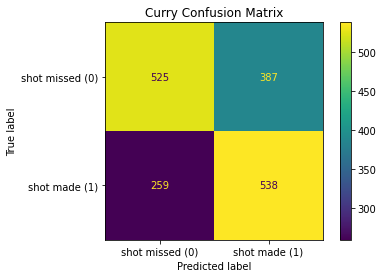

In [97]:
'''T9. Calculate precision and recall'''
# YOUR CODE HERE
# manually calculated precision and recall, 
instructor_precision =  538 / (387 + 538)
instructor_recall = 538 / (538 + 259)
print('Instuctor model precision', instructor_precision)
print('Instuctor model recall', instructor_recall)

Instuctor model precision 0.5816216216216217
Instuctor model recall 0.6750313676286073


**Task 9 Testing**

In [93]:
'''T9 Testing'''
assert isinstance(instructor_precision, float)
assert isinstance(instructor_recall, float)
assert 0 <= instructor_precision <= 1
assert 0 <= instructor_recall <= 1

**Task 10 (`stretch goal — optional`):** Plot confusion matrix for your model using your **test data**. Does your model have higher recall or higher precision? How does your model's metrics compare to the metrics you calculated above?

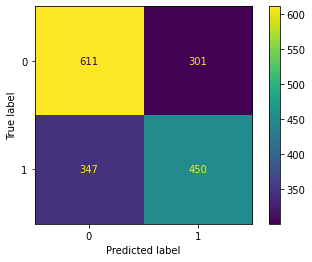

In [94]:
'''T10. Plot ROC curve.'''
# YOUR CODE HERE
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test, values_format='.0f')

In [102]:
# it looks like my model has higher precision by 3.45%
precision = 450 / (450 + 301)
recall = 450 / (450 + 347)
print(precision)
print(recall)
print(precision - recall)

0.5992010652463382
0.5646173149309912
0.034583750315346995


In [104]:
test_acc = model.score(X_test, y_test)
print('Test Accuracy Score:', test_acc)
# looks like my test score and validation score are
# similar to each other within 1% 

Test Accuracy Score: 0.6208308952603862


In [98]:

# now compare using the classification report
y_pred = model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.6378    0.6700    0.6535       912
           1     0.5992    0.5646    0.5814       797

    accuracy                         0.6208      1709
   macro avg     0.6185    0.6173    0.6174      1709
weighted avg     0.6198    0.6208    0.6199      1709

